In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [3]:
def rand_tensor(min=0, max=1, size=(1)):
    out = (max - min) * torch.rand(size) + min
    return out

In [4]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), batch_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.batch_size = batch_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.batch_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            y += coeffs*(x**d)
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return (torch.sum(out,dim=3), out), params


In [5]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    if params.size(1) > 2:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        c = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        return a*x**2 + b*x + c
    else:
        return torch.zeros_like(params)

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    if params.size(1) > 3:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        c = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        d = params[:, 3].type(torch.float).unsqueeze(1).to(device)
        return a*x**3 + b*x**2 + c*x + d
    else:
        return torch.zeros_like(params)

In [8]:
def polynomial_function(params, x, degree, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    ran = params.size(1)
    if params.ndim > 2:
        ran = params.size(2)
    for c in range(ran):
        if params.ndim > 2:
            coeff = params[:, 0, c, 0].type(torch.float).unsqueeze(1).to(device)
        else:
            coeff = params[:, c].type(torch.float).unsqueeze(1).to(device)
        y += coeff*(x**c)
    return y


In [6]:
class MyModel(nn.Module):
    def __init__(self, functions, x_data, input_channels, params, device):
        super().__init__()
        self.device = device
        self.functions = functions  # [[function, (...)], [# params, (...)]]
        self.x_data = x_data
        self.input_channels = input_channels
        self.params = params

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128), #28, 16
            nn.SELU(),
            nn.Linear(128, 64), #16, 8
            nn.SELU(),
            nn.Linear(64, self.params), #8
        )

    def forward(self, x, n=-1):
        lossFunc = nn.MSELoss()
        target_x = x.squeeze(2)
        x = torch.swapaxes(x, 1, 2).to(self.device)
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        

        output1 = self.functions[0][0](embedding[:, 0:2], self.x_data, device=self.device).to(device)
        output2 = self.functions[0][1](embedding[:, 2:], self.x_data, device=self.device).to(device) 
        
        best_embeds = []
        best_funcs = []
        losses = []
        best_losses = []

        for i in range(output1.size(0)):
            loss1 = lossFunc(output1[i], target_x[i])
            loss2 = lossFunc(output2[i], target_x[i])
            losses.append([loss1, loss2])
            if loss2.item() <= loss1.item():
                best_embeds.append(output2[i])
                best_funcs.append(self.functions[0][1])
                best_losses.append(loss2.item())
            else:
                best_embeds.append(output1[i])
                best_funcs.append(self.functions[0][0])
                best_losses.append(loss1.item())

        embeds = torch.stack(best_embeds, dim=0)
        return embeds, best_funcs, output1, output2, losses, best_losses


In [7]:
sample_size = 10000
batch_size = 250

x_values = torch.linspace(-1, 1, sample_size)
linear = Polynomial_func(x=x_values, range=[-1,1], degree=1, batch_size=sample_size, device=device)
quad = Polynomial_func(x=x_values, range=[-1,1], degree=2, batch_size=sample_size, device=device)
# cube = Polynomial_func(x=x_values, range=[-1,1], degree=3, batch_size=sample_size, device=device)

lin, _ = linear.generate()
lin_full,_ = lin
qua, _ = quad.generate()
qua_full,_ = qua
# cub, _ = cube.generate()
# cub_full,_ = cub

data = torch.vstack([lin_full, qua_full])#, cub_full])
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)


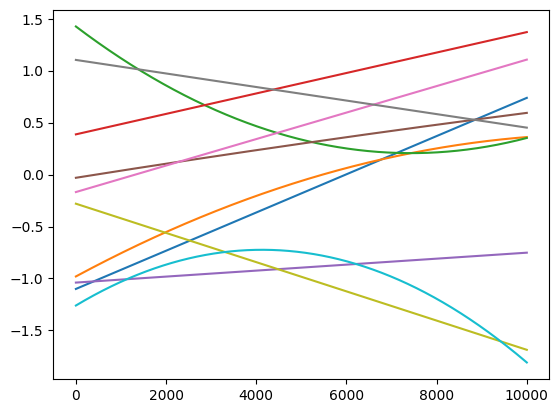

In [8]:
for i in range(10):
    plt.plot(data[np.random.randint(0, 20000), :, 0].detach().cpu().numpy(), "-")

In [9]:
model = MyModel(functions=[[linear_function, quadratic_function],[2,3]], x_data=x_values, input_channels=1, params=5, device=device)
model = model.to(device)
loss_func = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
epochs = 50
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()

    for train_batch in dataloader:
        train_batch = train_batch.to(device)
        target_batch = train_batch.squeeze(2).to(device)
        optimizer.zero_grad()
        # best_func, best_preds, min_loss, losses, embeds = model(train_batch)
        embeds, funcs, l, q, loss, best_loss = model(train_batch)
        #print(embeds.shape)
        #print(funcs)
        loss = loss_func(embeds,target_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * embeds.shape[0]
        total_num += embeds.shape[0]
    scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")


epoch : 0/50, loss = 0.16769220
--- 5.798902988433838 seconds ---
epoch : 1/50, loss = 0.02959650
--- 5.603457689285278 seconds ---
epoch : 2/50, loss = 0.01974150
--- 4.878212213516235 seconds ---
epoch : 3/50, loss = 0.01395727
--- 5.750633716583252 seconds ---
epoch : 4/50, loss = 0.00619786
--- 4.839614391326904 seconds ---
epoch : 5/50, loss = 0.00202830
--- 4.978900671005249 seconds ---
epoch : 6/50, loss = 0.00114932
--- 5.020174503326416 seconds ---
epoch : 7/50, loss = 0.00074668
--- 5.384085416793823 seconds ---
epoch : 8/50, loss = 0.00052426
--- 5.354249954223633 seconds ---
epoch : 9/50, loss = 0.00039443
--- 5.146263837814331 seconds ---
epoch : 10/50, loss = 0.00033758
--- 5.096165180206299 seconds ---
epoch : 11/50, loss = 0.00032955
--- 4.962554931640625 seconds ---
epoch : 12/50, loss = 0.00032108
--- 5.159759998321533 seconds ---
epoch : 13/50, loss = 0.00031304
--- 5.071619272232056 seconds ---
epoch : 14/50, loss = 0.00030515
--- 5.341475963592529 seconds ---
epoch

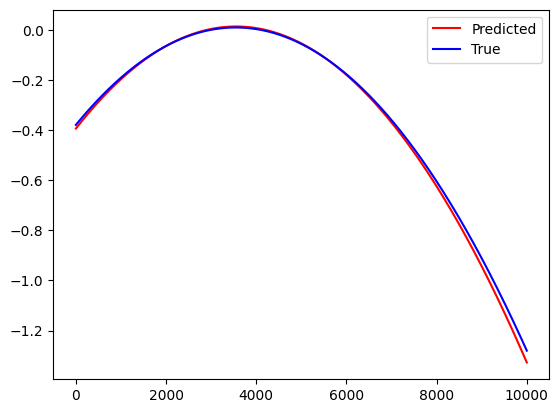

In [26]:
model.eval
best_embeds, best_funcs, linear, quad, loss, best_loss = model(train_batch)
rand = np.random.randint(0, 250)
plt.plot(best_embeds[rand, :].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(train_batch[rand, :].detach().cpu().numpy(), "b", label='True')
plt.legend();